# Deeplearning - Nasir Hussain - 2020/08/21

# 9 Advanced deep learning for computer vision

## 9.4 Interpreting what convnets learn

-  problem of a computer vision application is interpretability
- deep learning models are “black boxes”
  - they learn representations that are difficult to extract and present in a human-readable form
- convnets are highly amenable to visualization as they’re representations of visual concepts

- techniques for visualizing and interpreting
  - Visualizing intermediate convnet outputs
    - Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters
  - Visualizing convnet filters
    - Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to
  - Visualizing heatmaps of class activation in an image
    - Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

### 9.4.1 Visualizing intermediate activations

- display the values returned by various convolution and pooling layers in a model, given a certain input
-  how an input is decomposed into the different filters learned by the network.
- independently plotting the contents of every channel as a 2D image

In [ ]:
# load a model
from tensorflow import keras
model = keras.models.load_model("cats_vs_dogs_small_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Listing 9.6 Preprocessing a single image
from tensorflow import keras 
import numpy as np
 
# download a test image
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
  # open the image and resize it
  img = keras.utils.load_img(img_path, target_size=target_size)
  # turn image to numpy array (180,180,3)
  array = keras.utils.img_to_array(img)
  # add batch dimension (1,180,180,3)
  array = np.expand_dims(array, axis=0)
  return array
 
img_tensor = get_img_array(img_path, target_size=(180, 180))


90112/80329 [=================================] - 0s 1us/step


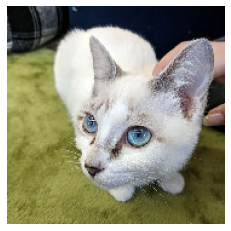

In [ ]:
# Listing 9.7 Displaying the test picture
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [ ]:
# create a Keras model that 
  # takes batches of images as input, 
  # and that outputs the activations of all convolution and pooling layers.
# Listing 9.8 Instantiating a model that returns layer activations
from tensorflow.keras import layers

layer_outputs = []
layer_names = [] 
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) 

-  this model returns the values of the layer activations in the original model, as a list
- 1 input, 9 outputs

In [ ]:
# Listing 9.9 Using the model to compute layer activations
activations = activation_model.predict(img_tensor)

In [ ]:
# activation of the first convolution layer for the cat image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


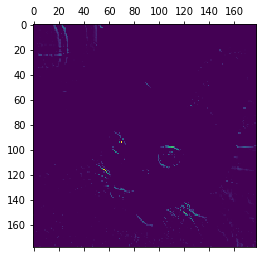

In [ ]:
# Listing 9.10 Visualizing the fifth channel
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

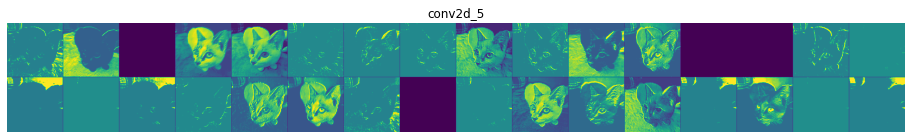

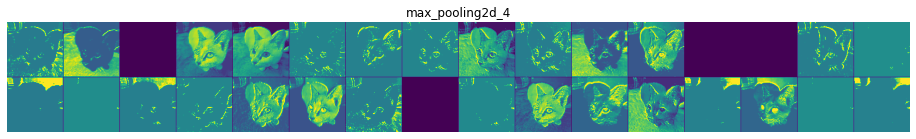

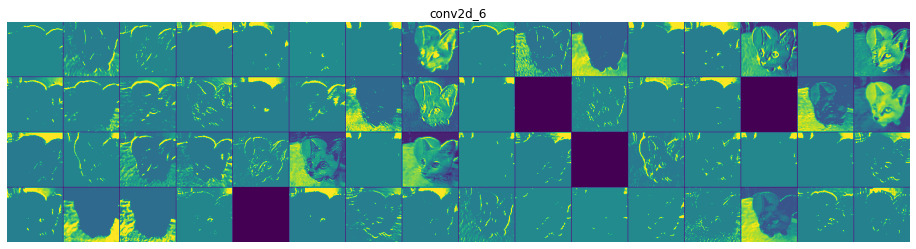

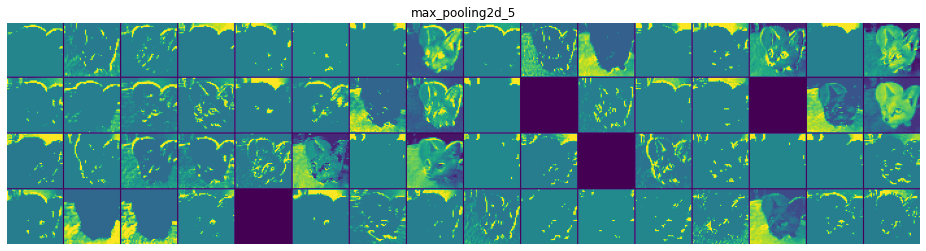

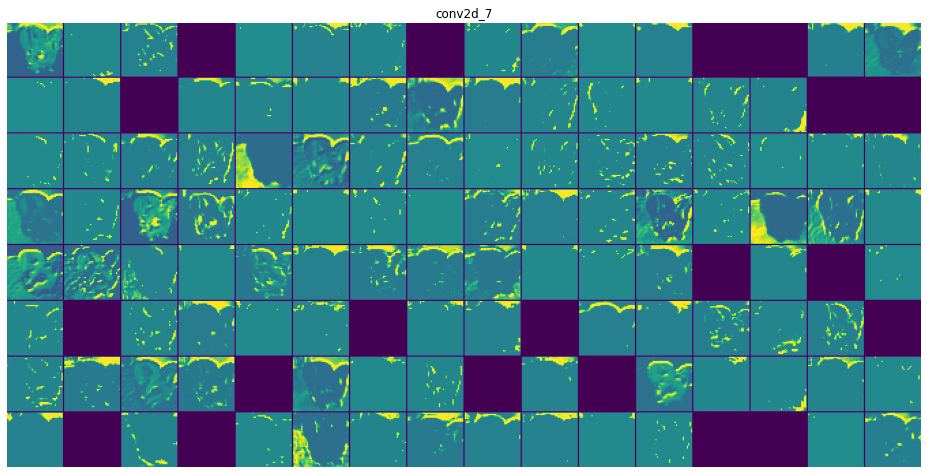

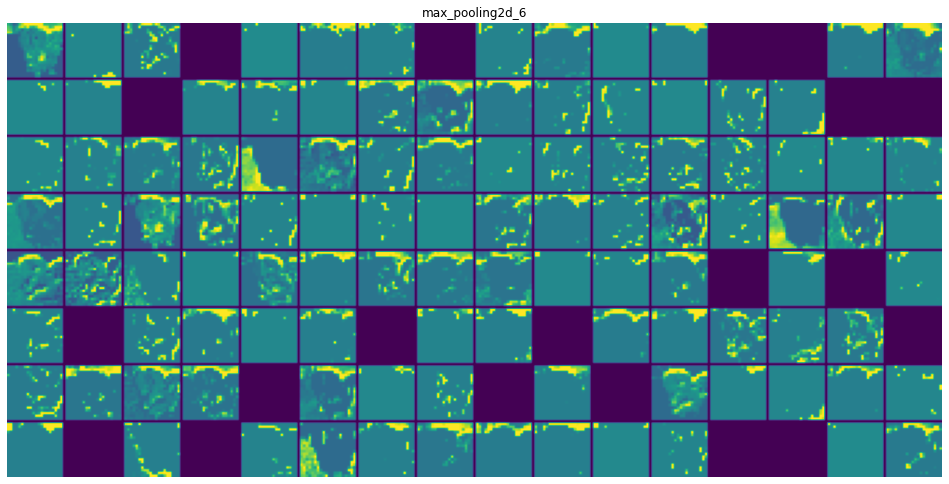

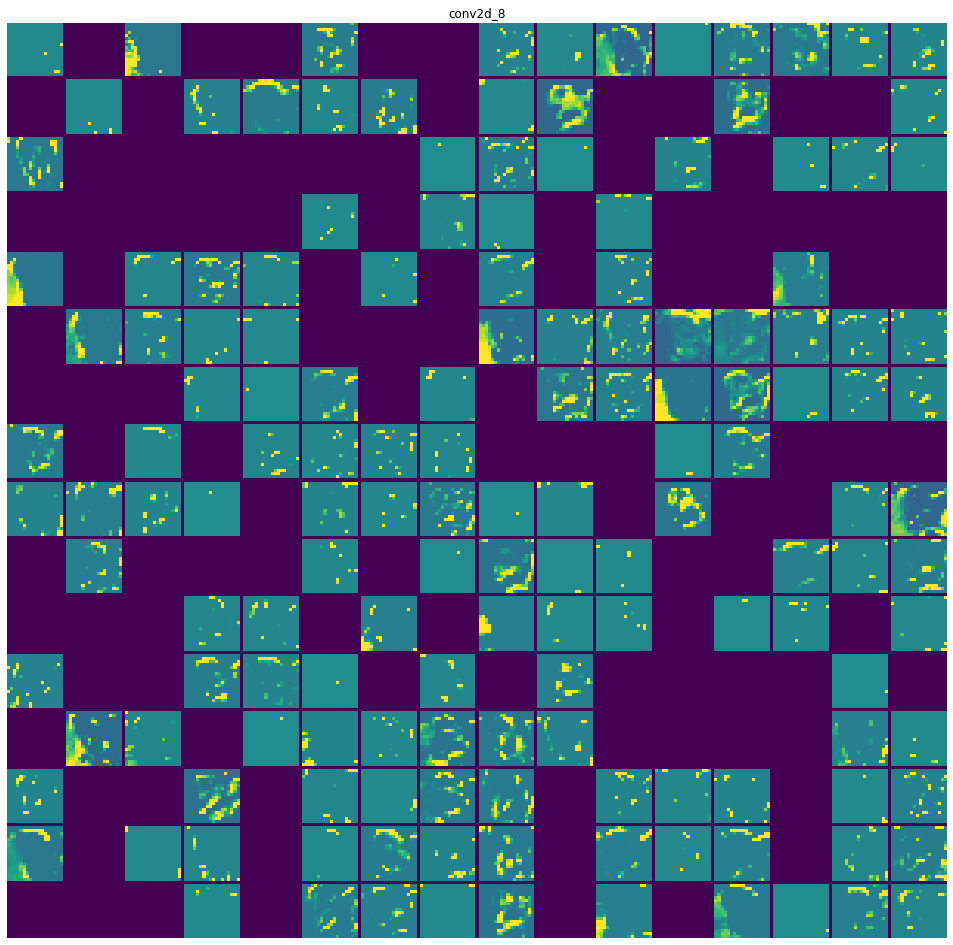

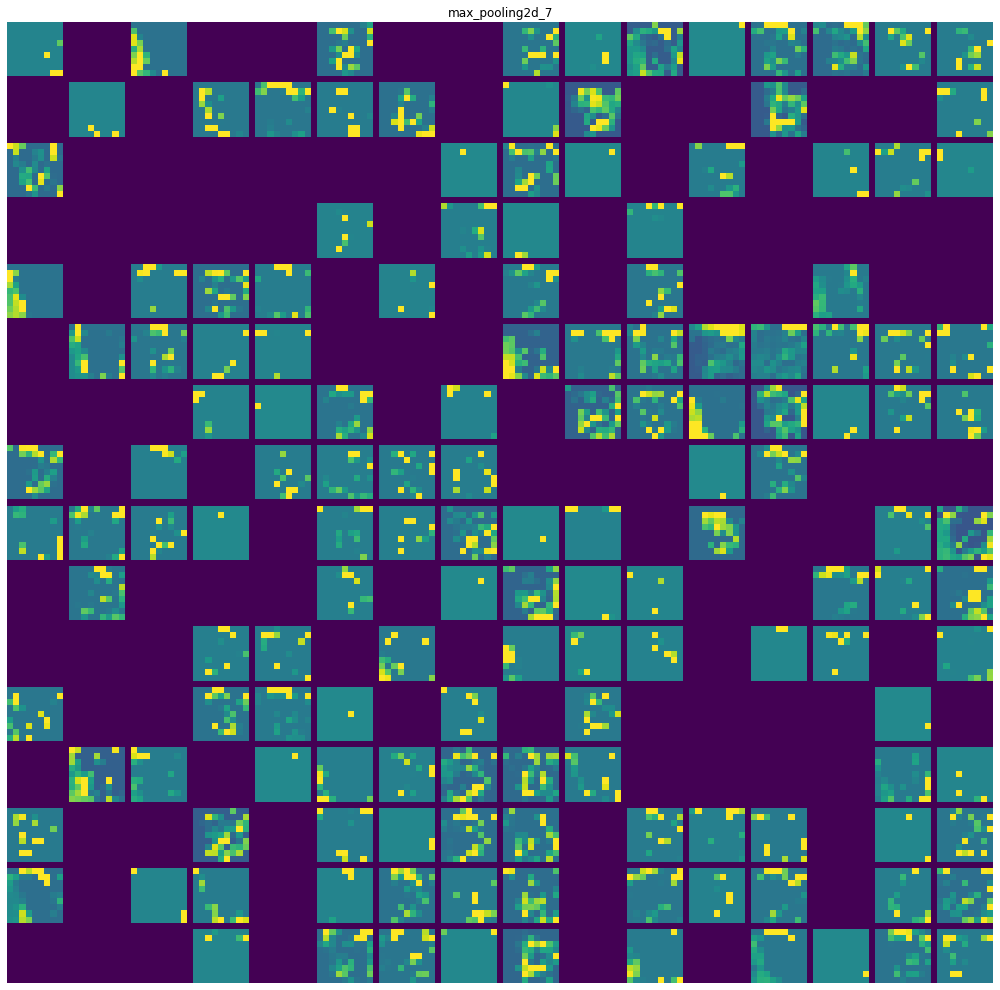

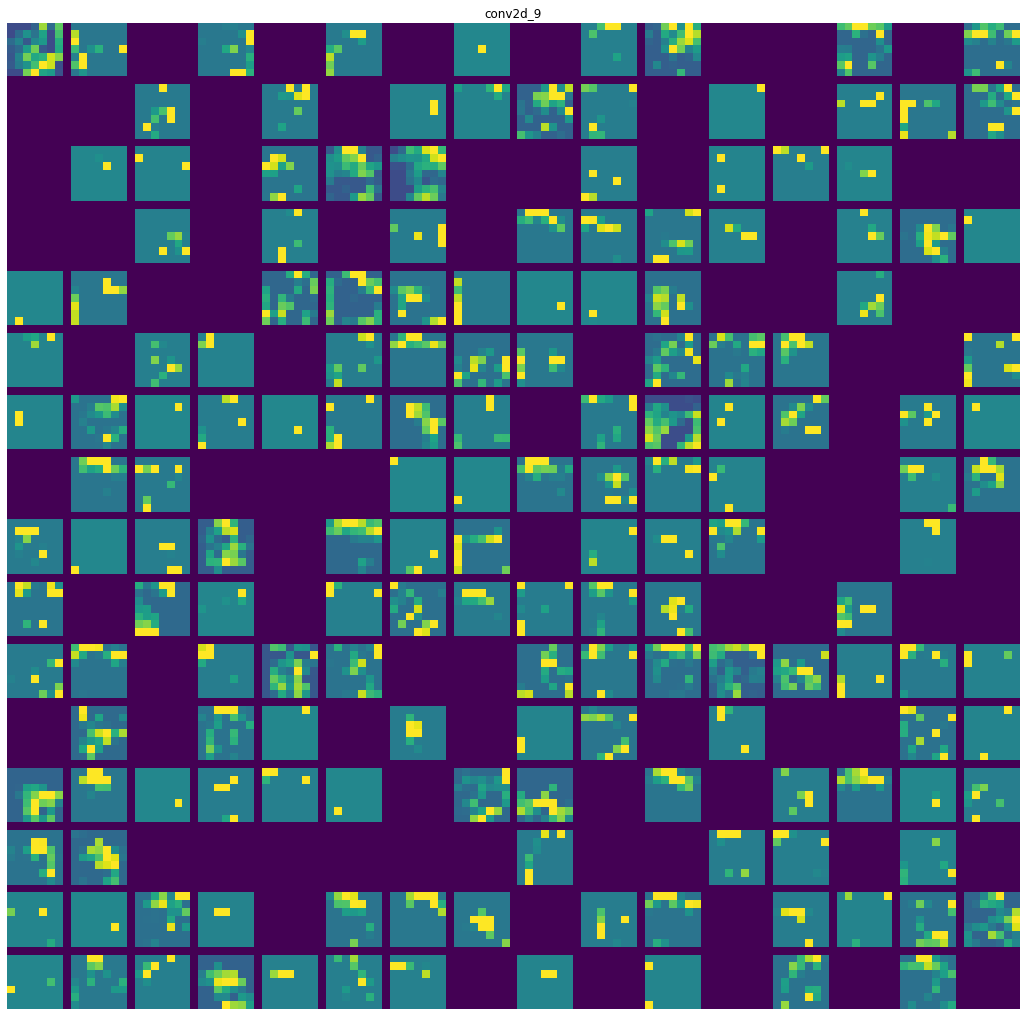

In [ ]:
# plot every channel in each of the layer activations
  # we’ll stack the results in one big grid, 
  # with channels stacked side by side
images_per_row = 16
# Iterate over the activations (and the names of the corresponding layers)
for layer_name, layer_activation in zip(layer_names, activations):
  # The layer activation has shape (1, size, size, n_features).
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  #  Prepare an empty grid for displaying all the channels in this activation.
  display_grid = np.zeros(((size + 1) * n_cols - 1,images_per_row * (size + 1) - 1))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      # This is a single channel (or feature).
      channel_image = layer_activation[0, :, :, channel_index].copy()
      #  Normalize channel values within the [0, 255] range. 
      # All-zero channels are kept at zero.
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype("uint8")
      # Place the channel matrix in the empty grid we prepared.
      display_grid[
        col * (size + 1): (col + 1) * size + col,
        row * (size + 1) : (row + 1) * size + row] = channel_image
  # Display the grid for the layer.
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.axis("off")
  plt.imshow(display_grid, aspect="auto", cmap="viridis") 

- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Deeper presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activations increases with the depth of the layer
  - in the first layer, almost all filters are activated by the input image
  - in the following layers, more and more filters are blank.
  - This means the pattern encoded by the filter isn’t found in the input image.

- Important universal characteristic of the representations learned by deep neural networks
  - the features extracted by a layer become increasingly abstract with the depth of the layer. 
- The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target 
- A deep neural network effectively acts as an information distillation pipeline, with raw data going in and being repeatedly transformed so that irrelevant information is filtered out, and useful information is magnified and refined

---

### 9.4.2 Visualizing convnet filters

- visual pattern that each filter is meant to respond to. 
  - can be done with gradient ascent in input space applying gradient descent to
    - the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.
- filters of the Xception model, pretrained on ImageNet
  - build a loss function that maximizes the value of a given filter in a given convolution layer
  - use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value.

In [ ]:
# Listing 9.12 Instantiating the Xception convolutional base
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False) 

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Listing 9.13 Printing the names of all convolutional layers in Xception
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [ ]:
# Listing 9.14 Creating a feature extractor model
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [ ]:
# Listing 9.6 Preprocessing a single image
from tensorflow import keras 
import numpy as np
 
# download a test image
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
  # open the image and resize it
  img = keras.utils.load_img(img_path, target_size=target_size)
  # turn image to numpy array (180,180,3)
  array = keras.utils.img_to_array(img)
  # add batch dimension (1,180,180,3)
  array = np.expand_dims(array, axis=0)
  return array
 
img_tensor = get_img_array(img_path, target_size=(180, 180))

In [ ]:
# Listing 9.15 Using the feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
# define a function that returns a scalar value quantifying 
  # how much a given input image “activates” a given filter in the layer

import tensorflow as tf
 
def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  # discard the first two pixels along the sides of the activation.
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [ ]:
# Listing 9.16 Loss maximization via stochastic gradient ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
      # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable
      tape.watch(image)
      #  Compute the loss scalar, indicating how much the current image activates the filter.
      loss = compute_loss(image, filter_index)
    # Compute the gradients of the loss with respect to the image.
    grads = tape.gradient(loss, image)
    # Apply the “gradient normalization trick.”
    grads = tf.math.l2_normalize(grads)
    # Move the image a little bit in a direction that activates our target filter more strongly.
    image += learning_rate * grads
    # Return the updated image so we can run the step function in a loop.
    return image

In [ ]:
# Listing 9.17 Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
  # Number of gradient ascent steps to apply
  iterations = 30
  # Amplitude of a single step
  learning_rate = 10.
  image = tf.random.uniform(
      minval=0.4,
      maxval=0.6,
      # Initialize an image tensor with random values
      shape=(1, img_width, img_height, 3))
  # Repeatedly update the values of the image tensor so as to maximize our loss function.
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
  return image[0].numpy()

In [ ]:
# Listing 9.18 Utility function to convert a tensor into a valid image
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype("uint8")
  image = image[25:-25, 25:-25, :]
  return image

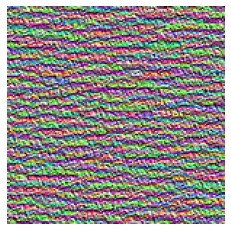

In [ ]:
# plot
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [ ]:
# Listing 9.19 Generating a grid of all filter response patterns in a layer
all_images = []
for filter_index in range(64):
  print(f"Processing filter {filter_index}")
  image = deprocess_image(
      generate_filter_pattern(filter_index)
  )
  all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
  for j in range(n):
    image = all_images[i * n + j]
    stitched_filters[
      (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
      (cropped_height + margin) * j : (cropped_height + margin) * j
      + cropped_height,
      :,
      ] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

![](./snaps/9.1-filters_for_layer_block3_sepconv1.png)

- each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. 
- This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. 
- The filters in these convnet filter banks get increasingly complex and refined as you go deeper in the model:
  - The filters from the first layers in the model encode simple directional edges and colors (or colored edges, in some cases).
  - The filters from layers a bit further up the stack, such as block4_sepconv1 , encode simple textures made from combinations of edges and colors.
  - The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

### 9.4.3 Visualizing heatmaps of class activation

- which parts of a given image led a convnet to its final classification decision
- debugging
  - a problem domain called model interpretability
  - allow you to locate specific objects in an image
- class activation map (CAM) visualization
  - producing heatmaps of class activation over input images.
- class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration

In [ ]:
# Listing 9.20 Loading the Xception network with pretrained weights
model = keras.applications.xception.Xception(weights="imagenet")

91897856/91884032 [==============================] - 1s 0us/step


In [ ]:
# Listing 9.21 Preprocessing an input image for Xception
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array

img_array = get_img_array(img_path, target_size=(299, 299))

745472/733657 [==============================] - 0s 0us/step


In [ ]:
# run the pretrained network on the image and decode its prediction vector back to a human readable format
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699269), ('n01871265', 'tusker', 0.076968454), ('n02504013', 'Indian_elephant', 0.023537213)]


In [ ]:
# Listing 9.22 Setting up a model that returns the last convolutional output
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
# Listing 9.23 Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input 
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
# Listing 9.24 Retrieving the gradients of the top predicted class
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
# Listing 9.25 Gradient pooling and channel-importance weighting
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

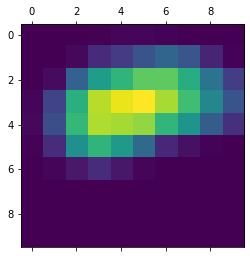

In [ ]:
# Listing 9.26 Heatmap post-processing
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
# Listing 9.27 Superimposing the heatmap on the original picture
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

![](./snaps/9.1-elephant_cam.jpg)

---